# Feature Selection

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE

## Data preparation

In [4]:
default = pd.read_csv('./data/credit_card_default.csv', index_col="ID")
default.rename(columns=lambda x: x.lower(), inplace=True)
default.rename(columns={'pay_0':'pay_1','default payment next month':'default'}, inplace=True)

default['grad_school'] = (default['education'] == 1).astype(int)
default['university'] = (default['education'] == 2).astype(int)
default['high_school'] = (default['education'] == 3).astype(int)
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex']==1).astype(int)
default['married'] = (default['marriage'] == 1).astype(int)
default.drop(['sex','marriage'], axis=1, inplace=True)

# For pay_n features if >0 then it means the customer was delayed on that month
pay_features = ['pay_' + str(i) for i in range(1,7)]
for p in pay_features:
    default[p] = (default[p] > 0).astype(int)

In [12]:
dummy_features =['pay_'+str(i) for i in range(1,7)]
dummy_features += ['male','married','grad_school','university','high_school']
numerical_features = [x for x in default.columns if x not in dummy_features+['default']]

### Applying the scaling operation

In [6]:
target_name = 'default'
X = default.drop('default', axis=1)
feature_names = X.columns
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]

## Removing dummy features with low variance

In [10]:
variances = pd.Series(default.var())

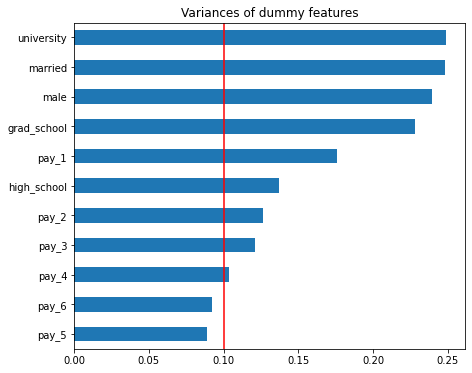

In [11]:
# Select a threshhold for what you want the variace to be above
fig, ax = plt.subplots(figsize=(7,6))
variances.loc[dummy_features].sort_values().plot(kind='barh', ax=ax)
ax.vlines(0.1, ymin=-1, ymax=25, colors='red')
ax.set_title('Variances of dummy features');

Candidate for elimination: pay_5 and pay_6

## Using SelectKBest

### For dummy features

In [14]:
# Chi-squared beacuse dummy features. k=all means apply test to all dummy features
dummy_selector = SelectKBest(chi2, k="all")
dummy_selector.fit(default[dummy_features], default[target_name])

SelectKBest(k='all', score_func=<function chi2 at 0x12b1e9670>)

In [15]:
# The larger the score value for Chi-squared the stronger the relationship between feature and target
dummy_selector.scores_

array([3141.39566361, 2920.6909149 , 2222.60680108, 2010.51973814,
       1926.49180212, 1630.3290955 ,   28.92210682,   14.48674466,
         51.149551  ,   21.23797331,   26.33631512])

In [16]:
# Features with p-value larger than 0.05 is not related with the target
dummy_selector.pvalues_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.53480421e-08, 1.41149283e-04,
       8.55902557e-13, 4.05647636e-06, 2.86844139e-07])

The p-value tells us there is a relationship between all dummy features and target

### For numerical features

In [18]:
# ANOVA F-value between label/feature for classification tasks
num_selector = SelectKBest(f_classif, k="all")
num_selector.fit(default[numerical_features], default[target_name])

SelectKBest(k='all')

In [19]:
num_selector.pvalues_

array([1.30224395e-157, 1.61368459e-002, 6.67329549e-004, 1.39573624e-002,
       1.47699827e-002, 7.85556416e-002, 2.41634443e-001, 3.52122521e-001,
       1.14648761e-036, 3.16665676e-024, 1.84177029e-022, 6.83094160e-023,
       1.24134477e-021, 3.03358907e-020])

In [20]:
# Select features with p-value above 0.05 because these are likely to be irrelevant to predict target
pd.Series(numerical_features).loc[num_selector.pvalues_>0.05]

5    bill_amt4
6    bill_amt5
7    bill_amt6
dtype: object

## Recursive Feature Elimination

the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

In [21]:
print("Number of featues:", X.shape[1])

Number of featues: 25


In [23]:
RF = RandomForestClassifier(n_estimators=100, max_depth=20, max_features='auto',
                            random_state=55, n_jobs=-1)

In [24]:
recursive_selector = RFE(estimator=RF, n_features_to_select=12)

In [25]:
recursive_selector = recursive_selector.fit(X, y)

In [26]:
recursive_selector.support_

array([ True,  True,  True, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False])

In [27]:
print('12 most important features:')
for x in feature_names[recursive_selector.support_]:
    print(x)

12 most important features:
limit_bal
age
pay_1
bill_amt1
bill_amt2
bill_amt3
bill_amt4
bill_amt5
bill_amt6
pay_amt1
pay_amt2
pay_amt3


In [28]:
print('Features to eliminate:')
for x in feature_names[~recursive_selector.support_]:
    print(x)

Features to eliminate:
pay_2
pay_3
pay_4
pay_5
pay_6
pay_amt4
pay_amt5
pay_amt6
grad_school
university
high_school
male
married


### Evaluating the full model versus the simpler model with cross-validation

In [23]:
selector_model = cross_validate(estimator=RF,X=X[:,recursive_selector.support_], y=y,
                            scoring=['recall','accuracy'], cv=10, n_jobs=-1)

full_model = cross_validate(estimator=RF,X=X,y=y,
                            scoring=['recall','accuracy'], cv=10, n_jobs=-1)

In [24]:
metrics = pd.DataFrame({'Full Model Recall':full_model['test_recall'],
                        'Full Model Accuracy':full_model['test_accuracy'],
                        'Selector Model Recall': selector_model['test_recall'],
                        'Selector Model Accuracy': selector_model['test_accuracy']})

In [25]:
metrics[['Full Model Recall','Selector Model Recall']].mean()

Full Model Recall        0.361365
Selector Model Recall    0.355791
dtype: float64

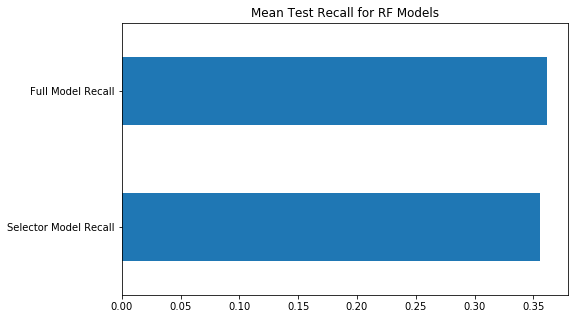

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
metrics[['Full Model Recall','Selector Model Recall']].mean().sort_values().plot(kind='barh', ax=ax)
ax.set_title('Mean Test Recall for RF Models');

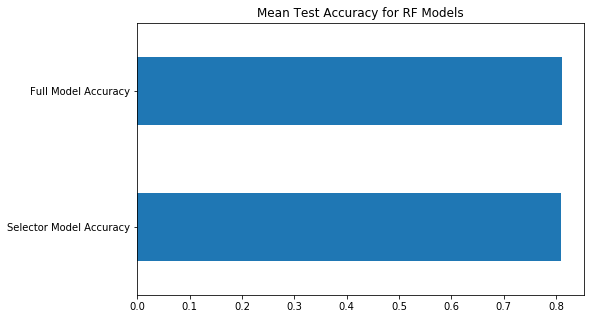

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
metrics[['Full Model Accuracy','Selector Model Accuracy']].mean().sort_values().plot(kind='barh', ax=ax)
ax.set_title('Mean Test Accuracy for RF Models');